# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [4]:
from agents import Agent_Q, SMDP_Agent_Q, Macro, SMDPQTable

from learning.q_learning import  q_learning
from learning.smdp_q_learning import smdp_q_learning

from learning.learning_params import *
from learning.run_learning import *

from utils.general import *
from utils.plotting import *

In [5]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

# Towers of Hanoi - Setup

In [7]:
print(learning_parameters("Q-Learning"))
print(learning_parameters("Imitation-SMDP-Q-Learning"))

{'alpha': 0.8, 'gamma': 0.95, 'lambd': 0.1, 'epsilon': 0.1}
{'alpha': 0.8, 'gamma': 0.95, 'lambd': 0.0, 'epsilon': 0.1}


In [7]:
learning_setup = {4: {"num_episodes": 300,
                      "max_steps": 500},
                  5: {"num_episodes": 1000,
                      "max_steps": 1000},
                  6: {"num_episodes": 5000,
                      "max_steps": 2000},
                  7: {"num_episodes": 10000,
                      "max_steps": 4000},
                  8: {"num_episodes": 20000,
                      "max_steps": 8000}}

### Simple TD($\lambda$) Learning

In [63]:
# Setup for N=4 Disk Towers of Hanoi Environment
log_episodes = 10
log_freq = 20

N = 4
num_episodes = learning_setup[N]["num_episodes"]
max_steps = learning_setup[N]["max_steps"]

env = gym.make("Hanoi-v0")
env.set_env_parameters(N, env_noise=0, verbose=False)

In [64]:
agent = Agent_Q(env)
params = learning_parameters(l_type="Q-Learning")
hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                             **params, log_freq=log_freq,
                             log_episodes=log_episodes, verbose=True)

Ep:  1 | Avg/Std Steps: 124.50/76.28 | Avg/Std Ret: 3.40/76.28 | Success R: 1.00
Ep: 21 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 41 | Avg/Std Steps: 18.00/0.00 | Avg/Std Ret: 41.81/0.00 | Success R: 1.00
Ep: 61 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 81 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 101 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 121 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 141 | Avg/Std Steps: 17.00/0.00 | Avg/Std Ret: 44.01/0.00 | Success R: 1.00
Ep: 161 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 181 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00


In [81]:
# Run Learning 5 times for 4 Disk Environment
num_times = 5
num_disks = 4
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_4, steps_4_q, sd_steps_4_q, rew_4_q, sd_rew_4_q = run_learning("Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

4 Disks - Q-Learning: Run 1/5 Done - Time: 1.42
4 Disks - Q-Learning: Run 2/5 Done - Time: 1.07
4 Disks - Q-Learning: Run 3/5 Done - Time: 1.2
4 Disks - Q-Learning: Run 4/5 Done - Time: 1.19
4 Disks - Q-Learning: Run 5/5 Done - Time: 1.64


In [82]:
# Run Learning 5 times for 5 Disk Environment
num_disks = 5
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_5, steps_5_q, sd_steps_5_q, rew_5_q, sd_rew_5_q = run_learning("Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

5 Disks - Q-Learning: Run 1/5 Done - Time: 22.72
5 Disks - Q-Learning: Run 2/5 Done - Time: 17.49
5 Disks - Q-Learning: Run 3/5 Done - Time: 22.73
5 Disks - Q-Learning: Run 4/5 Done - Time: 16.39
5 Disks - Q-Learning: Run 5/5 Done - Time: 16.48


In [21]:
get_rollout_policy(env, agent, max_steps, grammar=False)

deque([(0, (0, 0, 0, 0), 1, (2, 0, 0, 0)),
       (1, (2, 0, 0, 0), 0, (2, 1, 0, 0)),
       (2, (2, 1, 0, 0), 5, (1, 1, 0, 0)),
       (3, (1, 1, 0, 0), 1, (1, 1, 2, 0)),
       (4, (1, 1, 2, 0), 3, (2, 1, 2, 0)),
       (5, (2, 1, 2, 0), 2, (2, 0, 2, 0)),
       (6, (2, 0, 2, 0), 4, (0, 0, 2, 0)),
       (7, (0, 0, 2, 0), 5, (0, 0, 1, 0)),
       (8, (0, 0, 1, 0), 0, (1, 0, 1, 0)),
       (9, (1, 0, 1, 0), 1, (1, 2, 1, 0)),
       (10, (1, 2, 1, 0), 2, (0, 2, 1, 0)),
       (11, (0, 2, 1, 0), 5, (0, 1, 1, 0)),
       (12, (0, 1, 1, 0), 0, (1, 1, 1, 0)),
       (13, (1, 1, 1, 0), 1, (1, 1, 1, 2)),
       (14, (1, 1, 1, 2), 3, (2, 1, 1, 2)),
       (15, (2, 1, 1, 2), 2, (2, 0, 1, 2)),
       (16, (2, 0, 1, 2), 4, (0, 0, 1, 2)),
       (17, (0, 0, 1, 2), 3, (0, 0, 2, 2)),
       (18, (0, 0, 2, 2), 0, (1, 0, 2, 2)),
       (19, (1, 0, 2, 2), 1, (1, 2, 2, 2)),
       (20, (1, 2, 2, 2), 3, (2, 2, 2, 2))])

In [22]:
get_rollout_policy(env, agent, max_steps, grammar=True)

'bafbdcefabcfabdcedabd'

### Check Context-Free Grammar Inference

In [8]:
optimal_policies = {4: "abdaefabdcedabd",
                    5: "bafbcdbafecfbafbcdbcfecdbafbcdb",
                    6: "abdaefabdcedabdaefaedcefabdaefabdcedabdce"\
                        "faedcedabdaefabdcedabd",
                    7: "bafbcdbafecfbafbcdbcfecdbafbcdbafecfbafec"\
                        "dbcfecfbafbcdbafecfbafbcdbcfecdbafbcdbcfe"\
                        "cfbafecdbcfecdbafbcdbafecfbafbcdbcfecdbafbcdb"}

In [9]:
from grammars.cfg_grammar import *

In [11]:
get_macros("all", optimal_policies[4], 6, "sequitur", 2)

['1 a e f 1 c e d 1 \\n ', 'a b d ']


['abd']

In [12]:
get_macros("all", optimal_policies[4], 6, "lexis", 2)

[]


IndexError: list index out of range

In [13]:
os.getcwd()

'/Users/rtl/Dropbox/PHD_ECN/PROJECTS/ActionGrammars/code/grammars/Lexis'

### Imitation SMDP-Q-Learning

In [59]:
log_episodes = 10
log_freq = 20

N = 4
num_episodes = learning_setup[N]["num_episodes"]
max_steps = learning_setup[N]["max_steps"]

env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0, verbose=False)

In [60]:
macros = get_optimal_macros(N, "Sequitur")
agent = SMDP_Agent_Q(env, macros)
params = learning_parameters(l_type="SMDP-Q-Learning")
hist, er_buffer = smdp_q_learning(env, agent, num_episodes, max_steps,
                                  **params,
                                  log_freq=log_freq,
                                  log_episodes=log_episodes, verbose=True)

Ep:  1 | Avg/Std Steps: 254.17/157.82 | Avg/Std Ret: 2.00/157.82 | Success R: 0.60
Ep: 21 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 41 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 61 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 81 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 101 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 121 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 141 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 161 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00
Ep: 181 | Avg/Std Steps: 15.00/0.00 | Avg/Std Ret: 48.77/0.00 | Success R: 1.00


In [83]:
# Run Learning 5 times for 4 Disk Environment
num_times = 5
num_disks = 4
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_4, steps_4_smdp_imi, sd_steps_4_smdp_imi, rew_4_smdp_imi, sd_rew_4_smdp_imi = run_learning("Imitation-SMDP-Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

4 Disks - Imitation-SMDP-Q-Learning: Run 1/5 Done - Time: 1.23
4 Disks - Imitation-SMDP-Q-Learning: Run 2/5 Done - Time: 1.43
4 Disks - Imitation-SMDP-Q-Learning: Run 3/5 Done - Time: 1.05
4 Disks - Imitation-SMDP-Q-Learning: Run 4/5 Done - Time: 1.14
4 Disks - Imitation-SMDP-Q-Learning: Run 5/5 Done - Time: 1.28


In [84]:
# Run Learning 5 times for 5 Disk Environment
num_times = 5
num_disks = 5
num_episodes = learning_setup[num_disks]["num_episodes"]
max_steps = learning_setup[num_disks]["max_steps"]
env, agent, its_5, steps_5_smdp_imi, sd_steps_5_smdp_imi, rew_5_smdp_imi, sd_rew_5_smdp_imi = run_learning("Imitation-SMDP-Q-Learning", num_times, num_disks,
                                                                       num_episodes, max_steps,
                                                                       log_episodes, log_freq)

5 Disks - Imitation-SMDP-Q-Learning: Run 1/5 Done - Time: 23.92
5 Disks - Imitation-SMDP-Q-Learning: Run 2/5 Done - Time: 20.7
5 Disks - Imitation-SMDP-Q-Learning: Run 3/5 Done - Time: 23.63
5 Disks - Imitation-SMDP-Q-Learning: Run 4/5 Done - Time: 23.72
5 Disks - Imitation-SMDP-Q-Learning: Run 5/5 Done - Time: 25.26


In [99]:
its_all = [its_4, its_5]
steps_all = [[steps_4_q, steps_4_smdp_imi],
             [steps_5_q, steps_5_smdp_imi]]
sd_steps_all = [[sd_steps_4_q, sd_steps_4_smdp_imi],
                [sd_steps_5_q, sd_steps_5_smdp_imi]]
rew_all = [[rew_4_q, rew_4_smdp_imi],
           [rew_5_q, rew_5_smdp_imi]]
sd_rew_all = [[sd_rew_4_q, sd_rew_4_smdp_imi],
              [sd_rew_5_q, sd_rew_5_smdp_imi]]

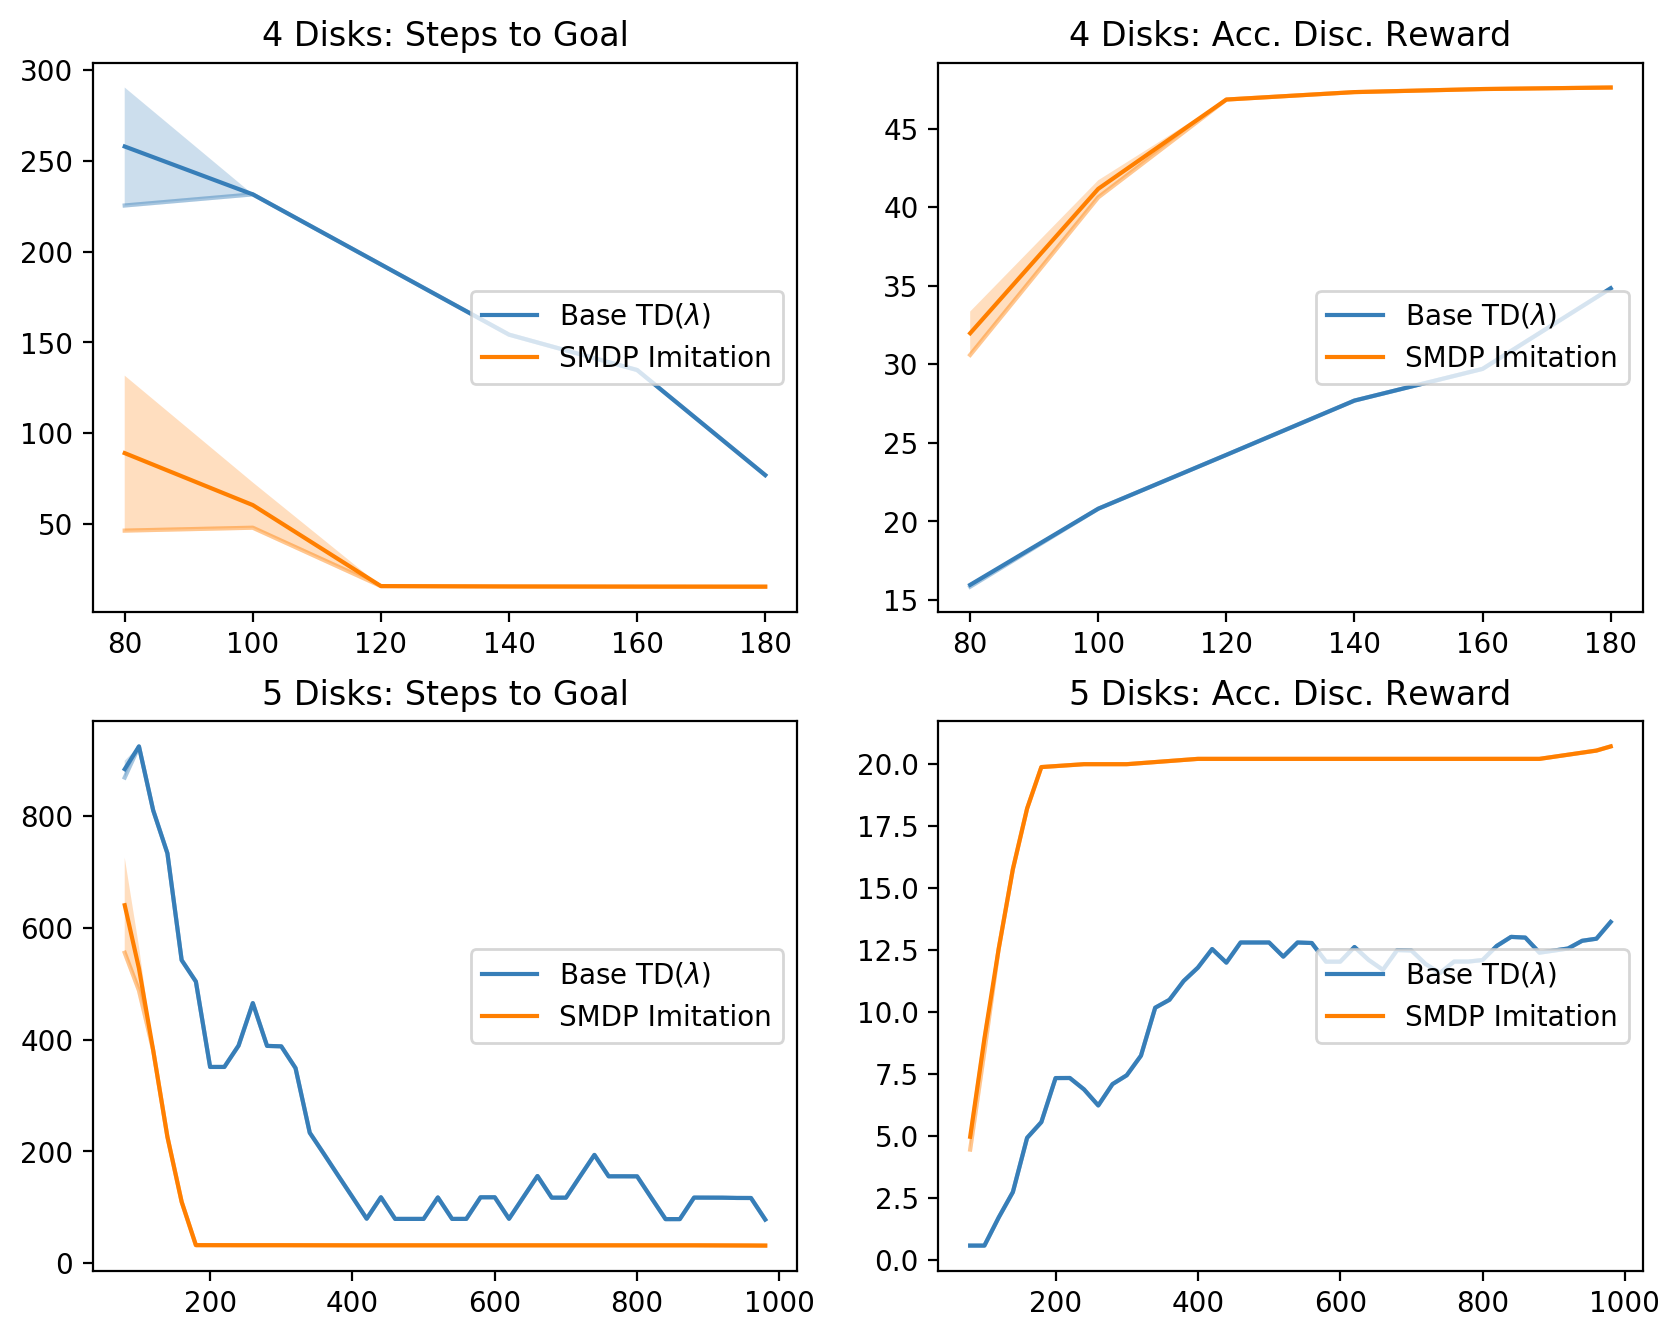

In [106]:
plot_all_learning(its_all, steps_all, sd_steps_all,
                  rew_all, sd_rew_all, smooth_degree=5,
                  sub_titles=[r"4 Disks: Steps to Goal",
                              r"4 Disks: Acc. Disc. Reward",
                              r"5 Disks: Steps to Goal",
                              r"5 Disks: Acc. Disc. Reward"],
                  labels=[r"Base TD($\lambda$)", "SMDP Imitation"])